In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import datetime
from joblib import Parallel, delayed
import multiprocessing
from lmfit import Parameters

In [2]:
num_cores = multiprocessing.cpu_count()
print(num_cores)

4


In [5]:
loc = '20201111-0943-01_PS_ODMR_10K_m21dBm_4mW_ODMR_data'
directory = 'C:/Data/Prime95B/2020/11/20201111/ODMR/'
all_data = np.load(directory+loc+'_ch0_raw_ODMR_data_sweep.npz')
x_data,_ = np.loadtxt(directory+loc+'_ch0.dat', skiprows=31, unpack=True)

In [6]:
slice_data = all_data['sweep_images'][:, :, :]
shape = np.shape(slice_data)
print(shape)
splitting = np.zeros((shape[1], shape[2]))
fwhm0 = np.zeros((shape[1], shape[2]))
fwhm1 = np.zeros((shape[1], shape[2]))

(60, 300, 300)


### Without parallel

In [ ]:
for i in tqdm(range(shape[1])):
    for j in range(shape[2]):        
        coord = (i,j)
        y_data = slice_data[:, coord[0], coord[1]]
        try:
            fit_result = fitlogic.make_lorentziandouble_fit(x_axis=x_data, data=y_data, estimator=fitlogic.estimate_lorentziandouble_peak)
            split = (fit_result.params['l1_center']-fit_result.params['l0_center'])
            fwhm0_ij = (fit_result.params['l0_fwhm'])
            fwhm1_ij = (fit_result.params['l1_fwhm'])
        except:
            split = np.nan
            fwhm0_ij = np.nan
            fwhm1_ij = np.nan
        splitting[i,j] = split
        fwhm0[i,j] = fwhm0_ij
        fwhm1[i,j] = fwhm1_ij
timestamp = datetime.datetime.now()
t = timestamp.strftime("%Y%m%d-%H%M-%S")
tag = '300x300'
np.savez_compressed('C:/Data/Prime95B/2020/08/20200821/ODMR/'+t+'YBCO_10K_0_Field_Bcool_0.88mT_12hr_ODMR_data_splitting_'+tag, data=splitting)
np.savez_compressed('C:/Data/Prime95B/2020/08/20200821/ODMR/'+t+'YBCO_10K_0_Field_Bcool_0.88mT_12hr_ODMR_data_fwhm0_'+tag, data=fwhm0)
np.savez_compressed('C:/Data/Prime95B/2020/08/20200821/ODMR/'+t+'YBCO_10K_0_Field_Bcool_0.88mT_12hr_ODMR_data_fwhm1_'+tag, data=fwhm1)

### Try with parallel

In [7]:
def do_fit(i):
    for j in range(shape[2]):        
        coord = (i,j)
        y_data = slice_data[:, coord[0], coord[1]]
        try:
            #params = Parameters()
            #Position 0: 2872660.0  90.0 kHz 
            #Position 1: 2888090.0  80.0 kHz 
            #params.add('l0_center', value=2872660000.0, min = 2872660000.0 - 5e6, max = 2872660000.0 + 5e6)
            #params.add('l1_center', value=2888090000.0, min = 2888090000.0 - 5e6, max = 2888090000.0 + 5e6)
            #params.add('l0_center', value=2871060000.0, min = 2860000000.0 - 5e6, max = 2878660000.0 + 5e6)
            #params.add('l1_center', value=2884090000.0, min = 2875090000.0 - 5e6, max = 2894090000.0 + 5e6)
           
            fit_result = fitlogic.make_lorentziandouble_fit(x_axis=x_data, data=y_data, estimator=fitlogic.estimate_lorentziandouble_peak)#, add_params=params)
            split = np.abs(fit_result.params['l1_center']-fit_result.params['l0_center'])
            if split>50e6:
                raise Exception
            fwhm0_ij = (fit_result.params['l0_fwhm'])
            fwhm1_ij = (fit_result.params['l1_fwhm'])
            #print(fit_result.values)
        except:
            split = np.nan
            fwhm0_ij = np.nan
            fwhm1_ij = np.nan
        splitting[i,j] = split
        fwhm0[i,j] = fwhm0_ij
        fwhm1[i,j] = fwhm1_ij

Parallel(n_jobs=4, prefer="threads")(delayed(do_fit)(i) for i in tqdm(range(shape[1])))

timestamp = datetime.datetime.now()
t = timestamp.strftime("%Y%m%d-%H%M-%S")
tag = 'fullxfull_parallel'
np.savez_compressed(directory+t+loc+'_splitting', data=splitting)
np.savez_compressed(directory+t+loc+'_fwhm0', data=fwhm0)
np.savez_compressed(directory+t+loc+'_fwhm1', data=fwhm1)
saveloc = directory+t+loc

100%|####################################################################################################################################################################################| 300/300 [4:36:29<00:00, 55.30s/it]


49931311.11146498


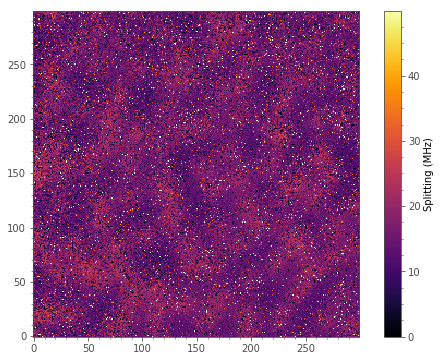

In [14]:
#data = np.load('C:/Data/Prime95B/2020/11/20201105/ODMR/20201105-1210-5720201105-0844-01_YBCO_LP=4mW_MW=-23dBm_diam1_ODMR_data_splitting.npz')
# %matplotlib inline
data = np.load(saveloc+'_splitting.npz')
splitting = data['data']
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='white')
plt.imshow(abs(splitting/1e6), cmap=plt.get_cmap('inferno'), origin='lower')#, vmax=23.0, vmin=10)
print(np.nanmax(splitting))
cb = plt.colorbar()
cb.set_label('Splitting (MHz)',size=10)
plt.show()

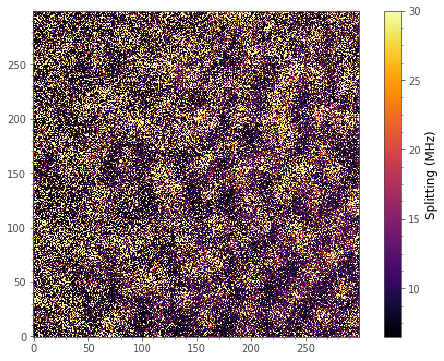

In [9]:
#data = np.load('C:/Data/Prime95B/2020/11/20201104/ODMR/20201104-1438-1720201104-0856-02_YBCO_LP=4mW_MW=-23dBm_ODMR_data_fwhm0.npz')
data = np.load(saveloc+'_fwhm0.npz')
splitting = data['data']
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='white')
plt.imshow(splitting/1e6, cmap=plt.get_cmap('inferno'), origin='lower', vmax=30, vmin=6.5)
cb = plt.colorbar()
cb.set_label('Splitting (MHz)',size=12)
plt.show()

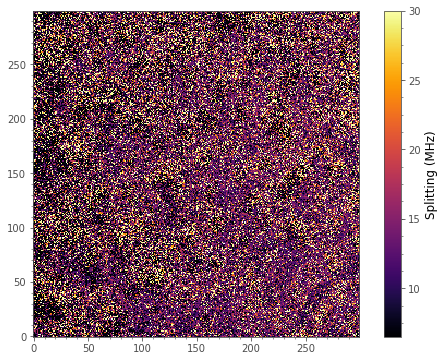

In [10]:
#data = np.load('C:/Data/Prime95B/2020/08/20200828/ODMR/20200828-1104-2420200828-0934-57_YBCO_10K_Bext_0.55mT_MW_-20dBm_after warm up_ODMR_data_fwhm1.npz')
data = np.load(saveloc+'_fwhm1.npz')
splitting = data['data']
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='white')
plt.imshow(splitting/1e6, cmap=plt.get_cmap('inferno'), origin='lower', vmax=30, vmin=6.5)
cb = plt.colorbar()
cb.set_label('Splitting (MHz)',size=12)
plt.show()

In [ ]:
fit_result.params.keys()

In [ ]:
np.savez_compressed(directory+t+loc+'_splitting', data=splitting)
np.savez_compressed(directory+t+loc+'_fwhm0', data=fwhm0)
np.savez_compressed(directory+t+loc+'_fwhm1', data=fwhm1)
saveloc = directory+t+loc

In [ ]:
def do_fit(i):
    for j in range(shape[2]):        
        coord = (i,j)
        y_data = slice_data[:, coord[0], coord[1]]
        try:
            #params = Parameters()
            #Position 0: 2872660.0 ± 90.0 kHz 
            #Position 1: 2888090.0 ± 80.0 kHz 
            #params.add('l0_center', value=2872660000.0)#, min = 2.86e9, max = 2.9e9)
            #params.add('l1_center', value=2888090000.0)#, min = 2.86e9, max = 2.9e9)
            fit_result = fitlogic.make_lorentziandouble_fit(x_axis=x_data, data=y_data, estimator=fitlogic.estimate_lorentziandouble_peak)#, add_params=params)
            split = np.abs(fit_result.params['l1_center']-fit_result.params['l0_center'])
            fwhm0_ij = (fit_result.params['l0_fwhm'])
            fwhm1_ij = (fit_result.params['l1_fwhm'])
#             print(fit_result.values)
        except:
            split = np.nan
            fwhm0_ij = np.nan
            fwhm1_ij = np.nan
        splitting[i,j] = split
        fwhm0[i,j] = fwhm0_ij
        fwhm1[i,j] = fwhm1_ij

Parallel(n_jobs=4, prefer="threads")(delayed(do_fit)(i) for i in tqdm(range(shape[1])))

timestamp = datetime.datetime.now()
t = timestamp.strftime("%Y%m%d-%H%M-%S")
# tag = 'fullxfull_parallel'
# np.savez_compressed(directory+t+loc+'_splitting', data=splitting)
# np.savez_compressed(directory+t+loc+'_fwhm0', data=fwhm0)
# np.savez_compressed(directory+t+loc+'_fwhm1', data=fwhm1)
# saveloc = directory+t+loc